In [1]:
!pip install --q seaborn

ERROR: tensorflow 2.13.1 has requirement numpy<=1.24.3,>=1.22, but you'll have numpy 1.24.4 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement absl-py<2,>=0.15, but you'll have absl-py 2.1.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement packaging<24,>=20.9, but you'll have packaging 24.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement pandas<2,>=1.0.0, but you'll have pandas 2.0.3 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement snowflake-snowpark-python<2,>=1.4.0, but you'll have snowflake-snowpark-python 1.0.0 which is incompatible.
ERROR: snowflake-connector-python 3.6.0 has requirement urllib3<2.0.0,>=1.21.1; python_version < "3.10", but you'll have urllib3 2.2.1 which is incompatible.
ERROR: openapi-spec-validator 0.7.1 has requirement jsonschema<5.0.0,>=4.18.0, but you'll have jsonschema 3.2.0 which is incompatible.
ERROR: openapi-schema-validator 0.6.2 has requirement jsonschema<5.0.0,>

In [2]:
!pip install --q xgboost

ERROR: tensorflow 2.13.1 has requirement numpy<=1.24.3,>=1.22, but you'll have numpy 1.24.4 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement absl-py<2,>=0.15, but you'll have absl-py 2.1.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement packaging<24,>=20.9, but you'll have packaging 24.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement pandas<2,>=1.0.0, but you'll have pandas 2.0.3 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement snowflake-snowpark-python<2,>=1.4.0, but you'll have snowflake-snowpark-python 1.0.0 which is incompatible.
ERROR: snowflake-ml-python 1.0.1 has requirement xgboost<2,>=1.7.3, but you'll have xgboost 2.0.3 which is incompatible.
ERROR: mosaic-ai-serving 1.0.0 has requirement Flask==2.1.1; python_version >= "3.7", but you'll have flask 2.2.5 which is incompatible.
ERROR: mosaic-ai-serving 1.0.0 has requirement matplotlib==3.6.0; python_version >= "3.8", but you'll have 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from numpy.random import randint
from multiprocessing import cpu_count
import os
import warnings
warnings.filterwarnings('ignore')

from snowflake.snowpark import Session
import configparser

Matplotlib created a temporary cache directory at /tmp/matplotlib-jwbdtrrm because the default path (/home/mosaic-ai/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline #pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE #for feature selection
#from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import (f1_score,classification_report,
                             roc_auc_score,confusion_matrix,roc_curve,auc) # evaluatin metrics
from sklearn.model_selection import KFold,RandomizedSearchCV ,cross_val_score,RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from xgboost import XGBClassifier
import gc

### Code to establish connection and read data from Snowflake

In [4]:
config = configparser.ConfigParser()
config.read("snowflake_connection.ini")

['snowflake_connection.ini']

In [5]:
connection_parameters = {
    "user": f'{config["Snowflake"]["user"]}',
    "password": f'{config["Snowflake"]["password"]}',
    #"password": os.getenv('snowflake_password'),
    "account": f'{config["Snowflake"]["account"]}',
    #"account": os.getenv('snowflake_account'),
    "WAREHOUSE": f'{config["Snowflake"]["WAREHOUSE"]}',
    "DATABASE": f'{config["Snowflake"]["DATABASE"]}',
    "SCHEMA": f'{config["Snowflake"]["SCHEMA"]}'
}

In [6]:
def snowflake_connector(conn):
    try:
        session = Session.builder.configs(conn).create()
        print("connection successful!")
    except:
        raise ValueError("error while connecting with db")
    return session

session = snowflake_connector(connection_parameters)

connection successful!


In [7]:
application_train_sf  = session.table("CRA_APPLICATION_TRAIN_DETAILS")
application_test_sf  = session.table("CRA_APPLICATION_TEST_DETAILS")

In [8]:
application_train = application_train_sf.to_pandas()

In [9]:
application_test = application_test_sf.to_pandas()

In [10]:
pd.set_option('display.max_rows', 30)
def info(table):
    print(f'\n the shape of the table is : \n',table.shape)
    print('-' * 80)
    print('\n data types : ', table.dtypes.value_counts().sort_values())
    print('-' * 80)
    missings=table.isna().mean()[table.isna().mean().sort_values(ascending=False)!=0].sort_values(ascending=False)
    print('-' * 80)
    print('\n number of features having missing data : ',len(missings))
    print('-' * 80)
    print('\n missing data in the table: \n',missings)
    print('-' * 80)
    print(missings[missings>0.5])
    print('-' * 80)
    print('\n missing data over 50% : ',len(missings[missings>0.5]))
info(application_train)


 the shape of the table is : 
 (307511, 124)
--------------------------------------------------------------------------------

 data types :  datetime64[ns]     1
int32              2
int16              2
object            17
int8              37
float64           65
Name: count, dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

 number of features having missing data :  61
--------------------------------------------------------------------------------

 missing data in the table: 
 COMMONAREA_MODE             0.698723
COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
                              ...   
EXT_SOURCE_2                0.002146
AMT_GOODS_PRICE             0.000904
AMT_ANNUITY                 0.000039
CNT_FAM_MEMBERS             0.000007
DAYS_LAST_PHON

The data we are working with contains307511 observations and 122 columns only 16 of them are categorical and the rest are numeric .
But the problem we are facing here is the huge amout of missing data with 67 columns contains missing informations with proportion more than 60% exceed threshold of 50% of missingness .
To tackle this problem we should do further analysis and select best strategies to handle them ,so let's start with the analysis first and keep this task to the processing step.

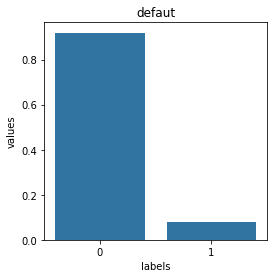

In [11]:
temp = application_train.TARGET.value_counts()
df1 = pd.DataFrame({'labels': temp.index,
                   'values': temp.values/len(application_train)})
plt.figure(figsize = (4,4))
plt.title('defaut')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df1)
locs, labels = plt.xticks()
plt.show()

From the distribution plot of the TARGET column we notice than our data suffers from imbalanced classes , There are far more loans that were repaid on time than loans that were not repaid.This may affect the model and results in biased predictions toward the non default class.It's important to choose the right option to handle this issue before running model.

In [12]:
NUMERIC_FEATURES = application_train.select_dtypes(['int8','int16','float16','int32','float32','int64','float64']).columns

In [13]:
application_train[NUMERIC_FEATURES].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000
